In [1]:
import logging

logging.basicConfig(level=logging.INFO)

In [2]:
dataset_metadata = {
    "monash_tourism_monthly": {"prediction_length": 24},
    "m4_hourly": {"prediction_length": 48},
}

dataset_choice = "monash_tourism_monthly"
num_time_series_subset = 2

In [3]:
from datasets import load_dataset
from autogluon.timeseries import TimeSeriesDataFrame

from src.data_preparation import to_gluonts_univariate, generate_test_X


prediction_length = dataset_metadata[dataset_choice]['prediction_length']
dataset = load_dataset("autogluon/chronos_datasets", dataset_choice)

tsdf = TimeSeriesDataFrame(to_gluonts_univariate(dataset['train']))
tsdf = tsdf[tsdf.index.get_level_values('item_id').isin(tsdf.item_ids[:num_time_series_subset])]
train_tsdf, test_tsdf_ground_truth = tsdf.train_test_split(prediction_length=prediction_length)
test_tsdf = generate_test_X(train_tsdf, prediction_length)

INFO:datasets:PyTorch version 2.5.1 available.


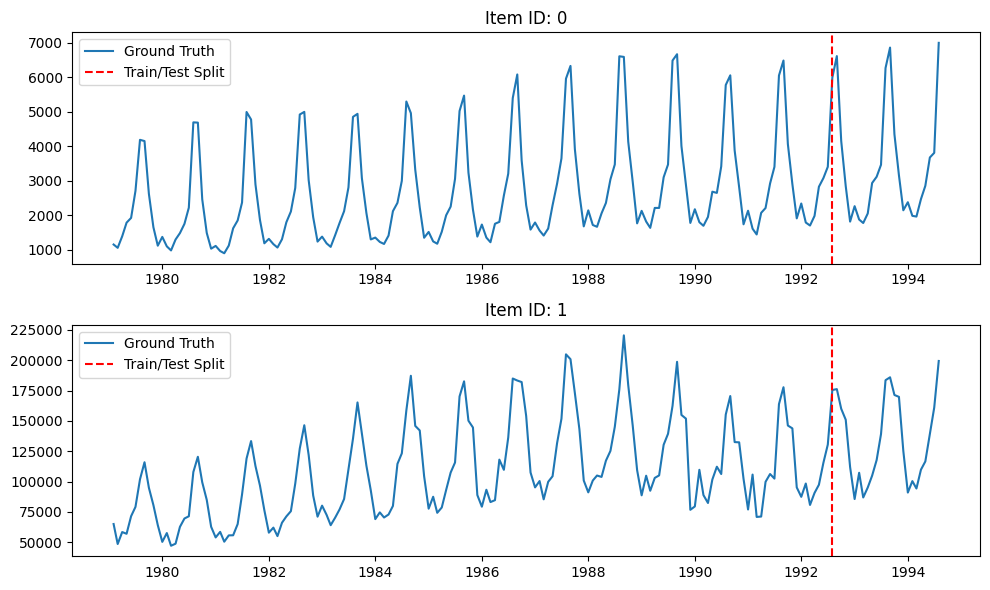

In [4]:
from src.plot import plot_actual_ts

plot_actual_ts(train_tsdf, test_tsdf_ground_truth)

In [5]:
from src.feature import FeatureTransformer, DefaultFeatures

selected_features = [
    DefaultFeatures.add_running_index,
    DefaultFeatures.add_calendar_features,
]

train_tsdf, test_tsdf = FeatureTransformer.add_features(
    train_tsdf, test_tsdf, selected_features
)


In [12]:
from src.predictor import TabPFNTimeSeriesPredictor, TabPFNMode

predictor = TabPFNTimeSeriesPredictor(
    tabpfn_mode=TabPFNMode.LOCAL,
)

pred = predictor.predict(train_tsdf, test_tsdf)

INFO:src.predictor:Predicting 2 time series with config{'optimize_metric': 'median', 'model_path': '/Users/shibinhoo/miniconda3/envs/tabpfn-time-series/lib/python3.10/site-packages/tabpfn/model_cache/model_hans_regression_2noar4o2.ckpt'}
Training + Prediction Passes:   0%|          | 0/8 [00:00<?, ?batch/s]/Users/shibinhoo/miniconda3/envs/tabpfn-time-series/lib/python3.10/site-packages/tabpfn/scripts/estimator/base.py:1663: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.fp16_inference):
Training + Prediction Passes:  12%|█▎        | 1/8 [00:00<00:04,  1.66batch/s]/Users/shibinhoo/miniconda3/envs/tabpfn-time-series/lib/python3.10/site-packages/tabpfn/scripts/estimator/base.py:1663: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=self.fp16_inference):
Traini

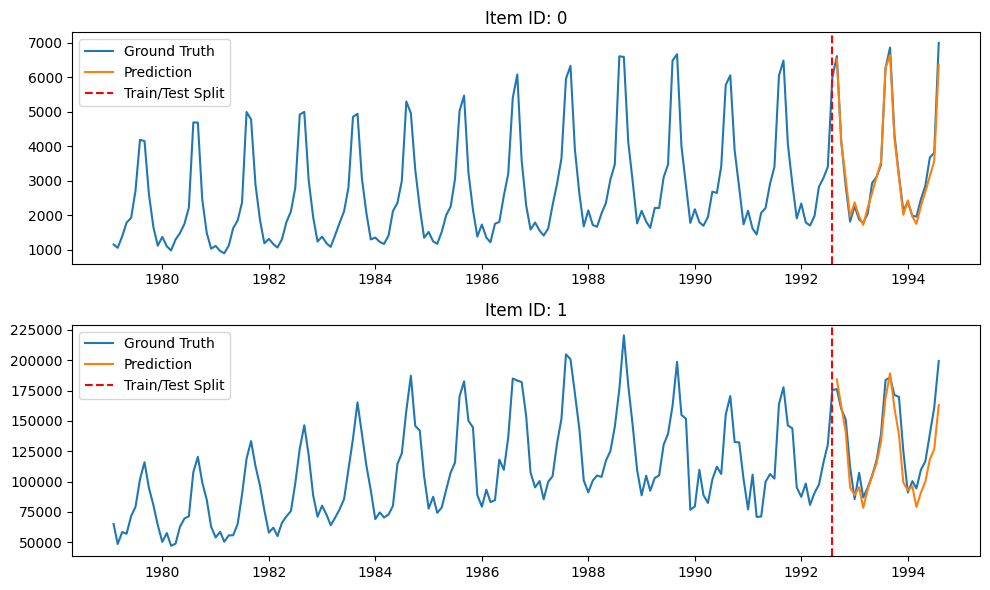

In [13]:
from src.plot import plot_pred_and_actual_ts

plot_pred_and_actual_ts(
    train=train_tsdf,
    test=test_tsdf_ground_truth,
    pred=pred,
)